In [2]:
import numpy as np
from cosmoTransitions import generic_potential_1
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special

####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


class model1(generic_potential_1.generic_potential):
    def init(self, ms = 50, theta = 0, muhs = 0, u = 100, mu3 = 0):
        self.Ndim = 2
        self.renormScaleSq = v2
        self.ms = ms
        self.theta = theta
        self.muhs = muhs
        self.u = u
        self.mu3 = mu3
        self.lamh = 1/(4*v2)*(mh**2+self.ms**2 + (mh**2 - ms**2)*np.cos(2*self.theta))
        #self.lams = 1/(2*self.u**2)*(mh**2*np.sin(self.theta)**2+self.ms**2*np.cos(self.theta)**2 + self.mu3*self.u + self.muhs*v**2/(2*self.u))
        self.lams = 1/(4*self.u**3)*(mh**2*self.u + ms**2*self.u + 2*self.u**2*self.mu3 + v**2*self.muhs - (mh**2-ms**2)*self.u*np.cos(2*self.theta))
        self.lammix = 1/(v*self.u)*(-(self.ms**2-mh**2)*np.sin(self.theta)*np.cos(self.theta) - self.muhs*v)
        self.muh2 = self.lamh*v2 + self.muhs*self.u + self.lammix/2*self.u**2
        self.mus2 = -self.mu3*self.u + self.lams*self.u**2 + self.muhs*v2/(2*self.u) + self.lammix/2*v2
        
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])
        #return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])
    
    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -1/2*self.muh2*h**2 + 1/4*self.lamh*h**4 - 1/2*self.mus2*s**2 - 1/3*self.mu3*s**3 + 1/4*self.lams*s**4 + 1/2*self.muhs*h**2*s + 1/4*self.lammix*h**2*s**2
        return pot
    
    def boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

       #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)
     
        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B
        
        ####Gauge boson masses (Longitudinal)
        mWL = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZL=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,g**2*h**2/4,h**2/4*(g**2+g1**2),mWL,mZL])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,4,2 , 2,1]) ##Longitudinal at the end
 

        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5,1.5,1.5])

        return M, dof, c, Mphys
     
    def oldboson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

    
        #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)
     
        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B
        
        ####Gauge boson masses
        mW = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZ=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,mW,mZ])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,6,3])


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,1.5,1.5])
        
        return M, dof, c, Mphys

    
    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=h**2/2
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))
        
        dof = np.array([12])
        return M, dof, Mphys
    

    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.
        v = v2**.5
        #return [np.array([v,self.u]), np.array([-v,-self.u]),np.array([v,-self.u]),np.array([-v,self.u])]
        #return [np.array([v,self.u]), np.array([-v,self.u])]
        #return []
        return [np.array([v,self.u])]
    
    def theory_consistent(self):
        perturbative_limit=4*np.pi
        perturbativity=self.lamh<=perturbative_limit and self.lams<=perturbative_limit and self.lammix<=perturbative_limit
        positivity=(self.lamh>0) and (self.lams>0) and (self.lammix>-2*(self.lamh*self.lams)**.5)
        if perturbativity and positivity:
            print("Model is theoretically consistent \n")
            return True
        else:
            print("Model is NOT theoretically consistent \n")
            return False
            
        
    def print_couplings(self):
        print("Potential parameters are given by \n ")
        print("mus2=",self.mus2, "muh2=",self.muh2,"lamh=",self.lamh,"lams=",self.lams,"lammix=",self.lammix,"\n")
        print("mu3=",self.mu3, "muhs=",self.muhs,"\n")
        print("Model parameters are \n")
        print("ms=",self.ms,"theta=",self.theta,"muhs=",self.muhs,"u=",self.u,"mu3=",self.mu3,"\n")
        
    def isEWSB(self):
        """Method to find the deepest minima of the potential at T=0"""
        n=20
        X_EW=np.array([v,self.u])
        minima=[]
        if self.muhs==0 and self.mu3==0:
            print("Model has a Z2 symmetry in the potential \n")
            print("isEWSB=True")
            return True
        for i in range(n):
            x1=np.random.uniform(0,4*self.Tmax)
            x2=np.random.uniform(-4*self.Tmax,4*self.Tmax)
            X0=self.findMinimum([x1,x2], T=0.0)
            if self.Vtot(X0,0)<=m.Vtot(X_EW,0):
                break
        print("Global minimum found at X=",X0,"\n")
        delta_r=np.sum((X0-X_EW)**2)<1
        print("isEWSB=",delta_r,"\n")
        return delta_r 


    

####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
data = np.loadtxt( 'satoshi_dof.dat' )
Temperature_d=(data.T)[0][900:3900]
dof_d=(data.T)[1][900:3900]
#f = interpolate.interp1d(Temperature_d, dof_d)###"""the function works from T=[10e-4,1000]"""
g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')
    


def alpha_GW(Tnuc,Drho):
    ####This code gives the parameter alpha relevant for stochastic GW spectrum 
 ##AS APPEAR IN FORMULA (8.2) OF 1912.12634
    num_dof=g_star(Tnuc)
    radiationDensity=np.pi**2/30*num_dof*Tnuc**4
    latentHeat=Drho
    return latentHeat/radiationDensity


 
def trans_class(SymNR):
    """Classify the transition according to the following characteristics:
    ---------
    phi-sym: transition happens in the s-field direction
    phi-symNR: transition happens in the s-field direction (symmetry is not restores at T=1000)
    """
    SNR="sym"
    if SymNR==True:
        SNR="SNR"
    
    if dh>10 and ds>10:
        return "hs-"+SNR
    elif dh>10 and ds<1:
        return "h-"+SNR
    elif ds>10 and dh<1:
        return "s-"+SNR
    else:
        return "none"+SNR
    
    
def my_getPhases(m):
    myexps=[(-5,-3),(-5,-5),(-5,-4),(-3,-3)]
    for nord in myexps:
        print("doing",nord)
        try:
            m.getPhases(tracingArgs={"dtstart":10**(nord[0]), "tjump":10**(nord[1])})
            phases_out=m.phases
        except:
            phases_out={}
        finally:
            if len(phases_out)>1:
                break
    return phases_out



def find_nucleation(m):
    """Find min and max temperatures to search for nucleation. IT will be used by bisection method.
    Parameters
        ----------
        m: a model instance. In this case m=model1(kk=1/600**2) for example.
    Returns
        -------
        nuc_dict: a dictionary containing the relevant temperatures and phases indexes.
                It will be used by the other methods to find the nucleation and percolation parameters
    """
    if m.phases is None:
        try:
            #phases_dict=m.getPhases()
            #phases_dict=m.getPhases(tracingArgs={"dtstart":1e-3, "tjump":1e-3})
            #phases_dict=m.getPhases(tracingArgs={"dtstart":1e-5, "tjump":1e-4})
            phases_dict=my_getPhases(m)
        except:
            return {}
    else:
        phases_dict=m.phases
    if len(phases_dict)<=1:
        return {}
    from cosmoTransitions import transitionFinder as tf
    crit_temps=tf.findCriticalTemperatures(phases_dict, m.Vtot)
    Num_relevant_trans=0
    ###DETERMINE IF THERE COULD BE TWO-STEP FOPTs
    for elem in crit_temps:
        if elem["trantype"]==1 and abs(elem["low_vev"][0]-elem["high_vev"][0])>10 and abs(elem["low_vev"][1]-elem["high_vev"][1])>10:
            print("Tunneling is relevant from phase " + str(elem["high_phase"])+ " to " + str(elem["low_phase"])  )
            Tmax=elem["Tcrit"]
            Tmin=phases_dict[elem["high_phase"]].T[0]
            print("max temperature is", Tmax)
            print("min temperature is", Tmin)
            Num_relevant_trans+=1
            high_phase_key=elem["high_phase"]
            low_phase_key=elem["low_phase"]
        else:
            continue
    if Num_relevant_trans==0:
        dict_output={}
        return dict_output
    else:
        dict_output= {"Tmin":Tmin, "Tmax":Tmax, "high_phase": high_phase_key,"low_phase": low_phase_key}
    X0=m.phases[dict_output["high_phase"]].X[0]
    T0=m.phases[dict_output["high_phase"]].T[0]
    stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
    #print("DOING WHILE LOOP \n")
    #while stable:
    #    if T0<=0:
    #        break
    #    T0-=1e-4
    #    X0=m.findMinimum(X0,T0)
    #    if abs(X0[0])>0.1:
    #        break
    #    stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
    #    print(" ................. \n")
    #    if stable==False:
    #        break
    def findminT(T):
        """Function to find the minimum temperature at which the high_vev coexists.
        Written in form for optimization"""
        Xmin=m.findMinimum(X0,T)
        dx=np.sum((Xmin-X0)**2)**0.5
        stable=not np.any(np.linalg.eig(m.d2V(Xmin,T))[0]<=0)
        if stable and (dx<.1) == False or T<0:
            return 500
        else:
            return stable and (dx<.1) + T
    Tmin_opt=optimize.fminbound(findminT,0,T0)
    dict_output["Tmin"]=Tmin_opt
    return dict_output


In [3]:
#df1=pd.read_csv("./SCANS/On_Shell_1.csv",index_col=[0])
#df2=pd.read_csv("./SCANS/On_Shell_2.csv",index_col=[0])
#df3=pd.read_csv("./SCANS/On_Shell_3.csv",index_col=[0])

#df_tot=pd.concat([df1,df2,df3])
#df_tot.to_csv("./SCANS/On_Shell.csv")

In [4]:
df_OS=pd.read_csv("./SCANS/On_Shell.csv",index_col=[0]).sort_values("alpha_max")
df_OS_strongFOPT=df_OS[df_OS.alpha_max>0]


In [5]:
print("Checking theoretical consistency")
df_test=df_OS_strongFOPT
perturbativity_bool=np.logical_and(np.logical_and(df_test.lamh<=4*np.pi, df_test.lams<=4*np.pi),
                                   df_test.lammix<=4*np.pi)

positivity_bool=np.logical_and(np.logical_and(df_test.lamh>0,df_test.lams>0),
                               df_test.lammix>-2*(df_test.lamh)**0.5*(df_test.lams)**0.5)


sum(perturbativity_bool)==len(df_test),sum(positivity_bool)==len(df_test)




Checking theoretical consistency


(True, True)

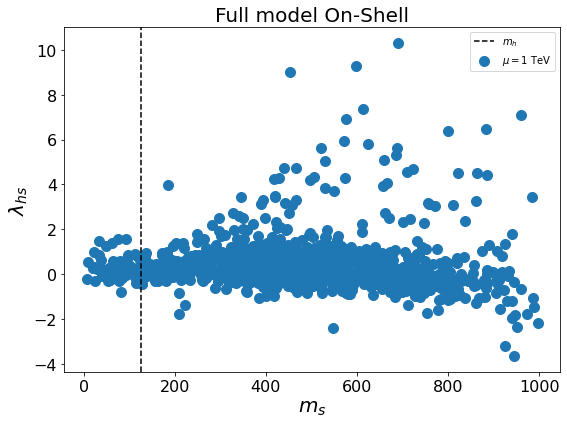

In [6]:
figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.ms,df_OS_strongFOPT.lammix,label="$\\mu= 1$ TeV",s=100)
plt.axvline(x=mh,linestyle="--",color="k",label="$m_h$")

#plt.xlim(50,300)
plt.ylabel("$\\lambda_{hs}$",size=label_size)
plt.xlabel("$m_s$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()



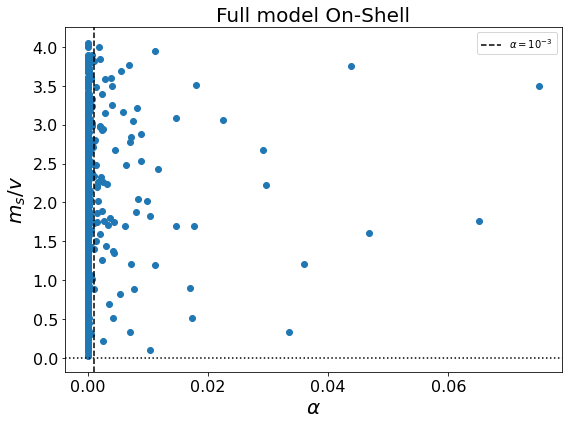

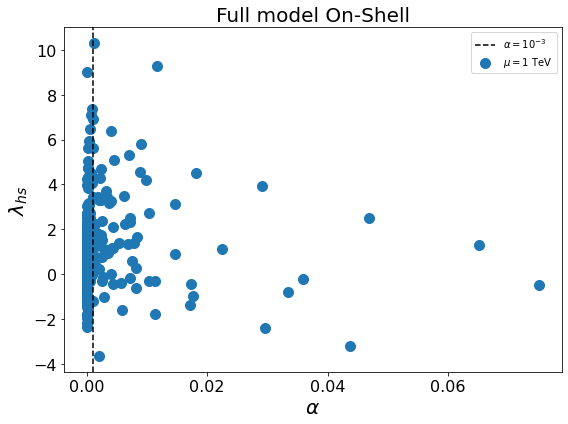

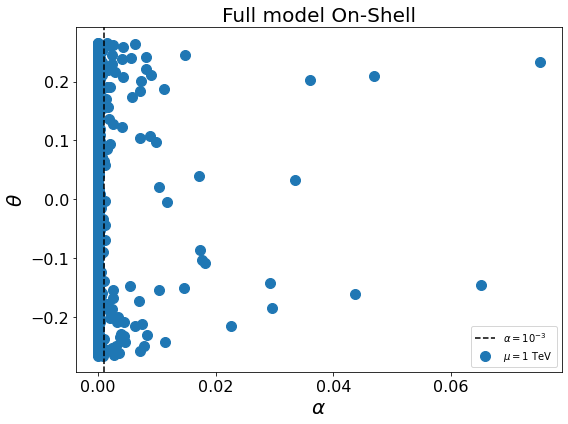

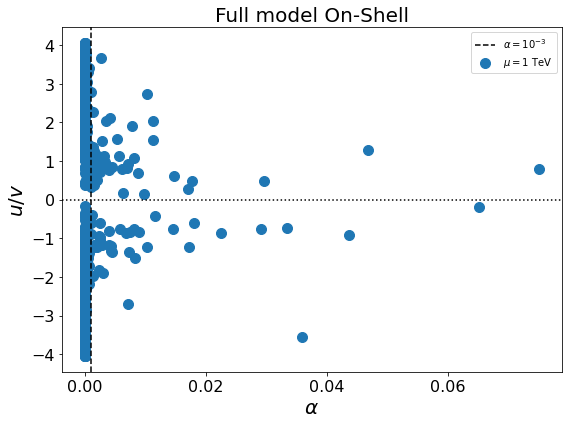

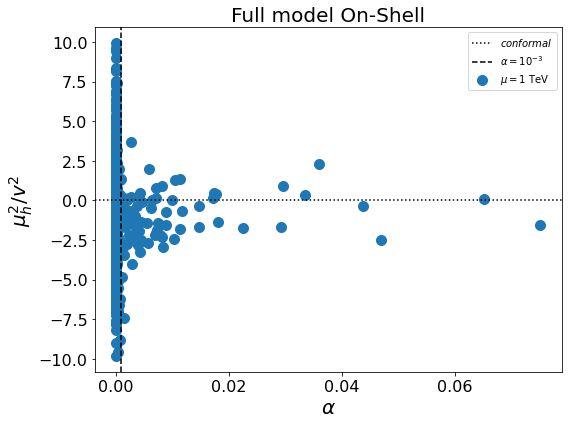

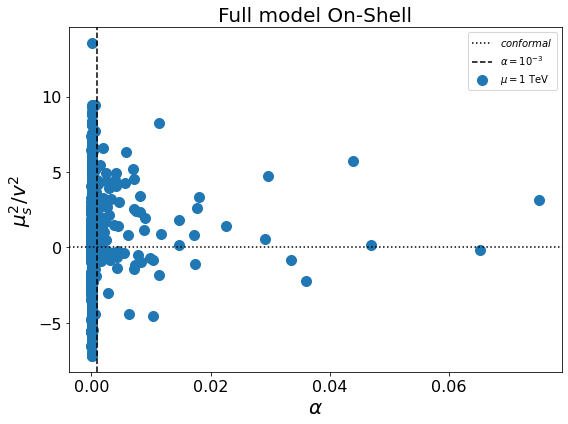

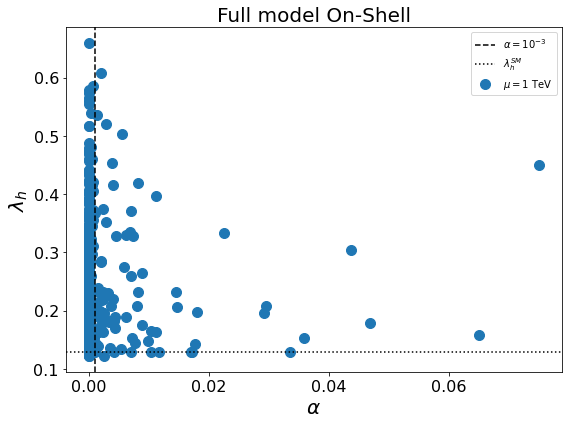

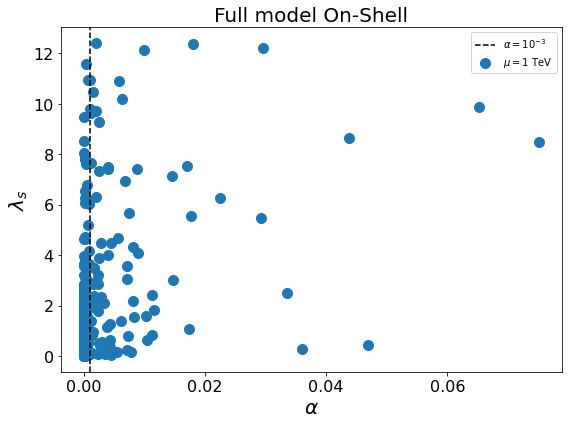

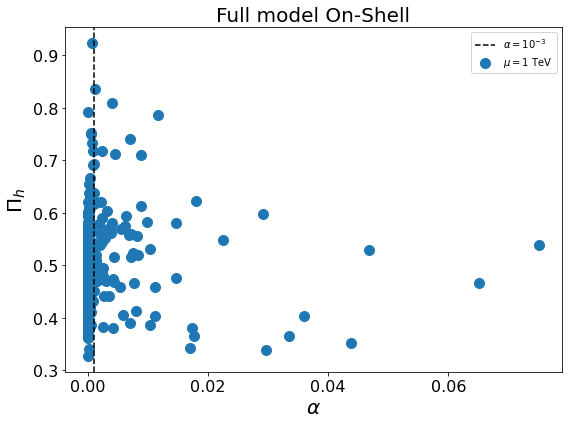

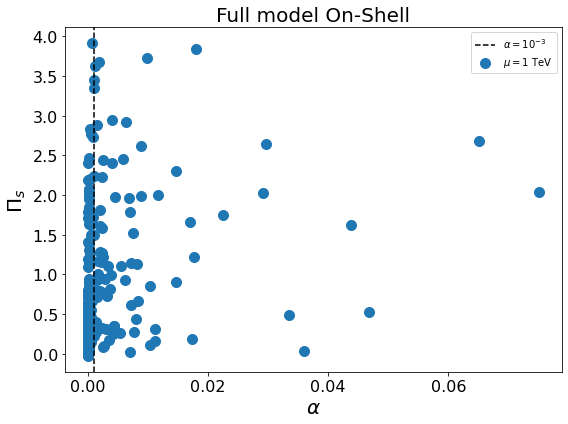

In [7]:
figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.ms/v)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.axhline(y=mh,linestyle=":",color="k",label="$m_h$")
plt.axhline(y=0,linestyle=":",color="k")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$m_s/v$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()


figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.lammix,label="$\\mu= 1$ TeV",s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\lambda_{hs}$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()



figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.theta,label="$\\mu= 1$ TeV",s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\theta$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()


figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.u/v,label="$\\mu= 1$ TeV",s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
plt.axhline(y=0,linestyle=":",color="k")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$u/v$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()


figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.muh2/v**2,label="$\\mu= 1$ TeV",s=100)
plt.axhline(y=0,linestyle=":",color="k",label="$conformal$")
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\mu_{h}^2/v^2$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.mus2/v**2,label="$\\mu= 1$ TeV",s=100)
plt.axhline(y=0,linestyle=":",color="k",label="$conformal$")
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\mu_{s}^2/v^2$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()



figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.lamh,label="$\\mu= 1$ TeV",s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
plt.axhline(y=mh**2/2/v**2,linestyle=":",color="k",label="$\\lambda_{h}^{SM}$")

#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\lambda_h$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()


figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.lams,label="$\\mu= 1$ TeV",s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\lambda_s$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()


figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.Pih,label="$\\mu= 1$ TeV",s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\Pi_h$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()


figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.Pis,label="$\\mu= 1$ TeV",s=100)
plt.axvline(x=0.001,linestyle="--",color="k",label="$\\alpha=10^{-3}$")
#plt.xlim(50,300)
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$\\Pi_s$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()




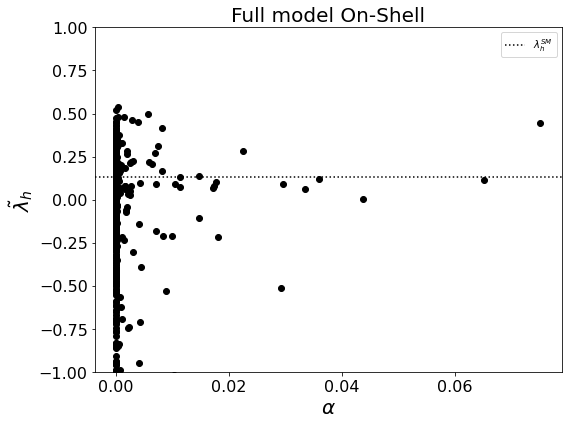

In [8]:
figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.lamh_tilde,color="k")
plt.axhline(y=mh**2/2/v**2,linestyle=":",color="k",label="$\\lambda_{h}^{SM}$")
plt.ylabel("$\\tilde{\\lambda}_h$",size=label_size)
plt.xlabel("$\\alpha$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
plt.ylim(-1,1)
#plt.xlim(0,.2)
plt.locator_params(axis='x', nbins=5)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()

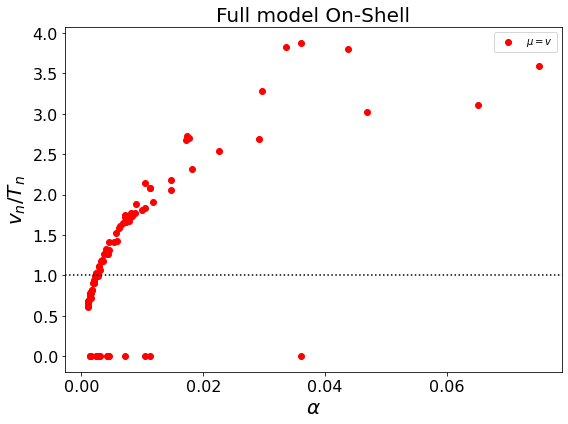

In [10]:
df_OS=pd.read_csv("./SCANS/On_Shell.csv",index_col=[0]).sort_values("alpha_max")
df_OS_strongFOPT=df_OS[df_OS.alpha_max>1e-3]

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.h_low_0/df_OS_strongFOPT.Tnuc_0,color="r",label="$\mu=v$")
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.h_low_1/df_OS_strongFOPT.Tnuc_1,color="r")
plt.scatter(df_OS_strongFOPT.alpha_max,df_OS_strongFOPT.h_low_2/df_OS_strongFOPT.Tnuc_2,color="r")
plt.axhline(y=1,linestyle=":",color="k")
plt.locator_params(axis='x', nbins=5)
#plt.axvline(x=mh**2/2/v**2,linestyle="--",color="k",label="$\\lambda_{SM}$")
plt.xlabel("$\\alpha$",size=label_size)
plt.ylabel("$v_n/T_n$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.legend()
plt.show()

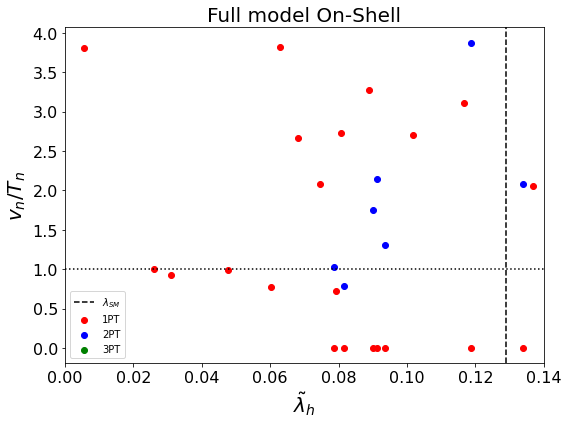

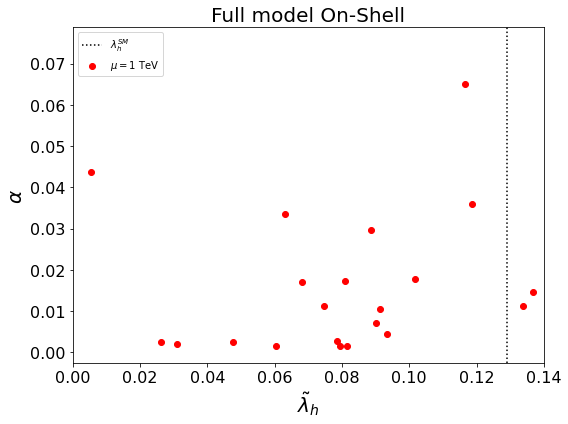

In [12]:
df_OS=pd.read_csv("./SCANS/On_Shell.csv",index_col=[0]).sort_values("alpha_max")
df_OS_strongFOPT=df_OS[df_OS.alpha_max>1e-3]

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.lamh_tilde,df_OS_strongFOPT.h_low_0/df_OS_strongFOPT.Tnuc_0,color="r",label="1PT")
plt.scatter(df_OS_strongFOPT.lamh_tilde,df_OS_strongFOPT.h_low_1/df_OS_strongFOPT.Tnuc_1,color="b",label="2PT")
plt.scatter(df_OS_strongFOPT.lamh_tilde,df_OS_strongFOPT.h_low_2/df_OS_strongFOPT.Tnuc_2,color="g",label="3PT")
plt.xlim(0,0.14)
plt.axhline(y=1,linestyle=":",color="k")
plt.axvline(x=mh**2/2/v**2,linestyle="--",color="k",label="$\\lambda_{SM}$")
plt.xlabel("$\\tilde{\\lambda}_h$",size=label_size)
plt.ylabel("$v_n/T_n$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.legend()
plt.show()


figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.lamh_tilde,df_OS_strongFOPT.alpha_max,label="$\\mu= 1$ TeV",color="r")
plt.xlim(0,0.14)
plt.axvline(x=mh**2/2/v**2,linestyle=":",color="k",label="$\\lambda_{h}^{SM}$")
plt.xlabel("$\\tilde{\\lambda}_h$",size=label_size)
plt.ylabel("$\\alpha$",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.legend()
#plt.ylim(0,1000)
#plt.xlim(0,.2)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.show()


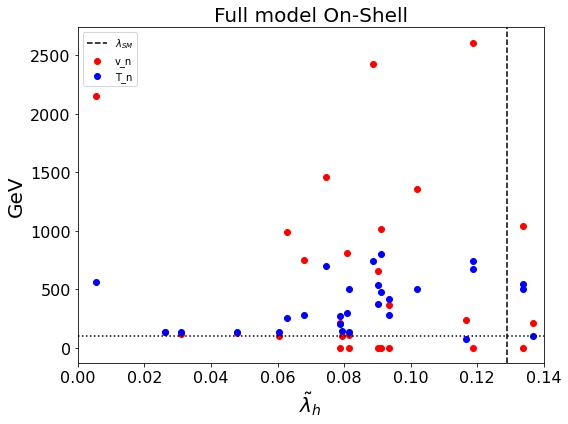

In [14]:
df_OS=pd.read_csv("./SCANS/On_Shell.csv",index_col=[0]).sort_values("alpha_max")
df_OS_strongFOPT=df_OS[df_OS.alpha_max>1e-3]

figure = plt.gcf()
figure.set_size_inches(8, 6)
thick_size=16
label_size=20
plt.scatter(df_OS_strongFOPT.lamh_tilde,df_OS_strongFOPT.h_low_0,color="r",label="v_n")
plt.scatter(df_OS_strongFOPT.lamh_tilde,df_OS_strongFOPT.h_low_1,color="r")
plt.scatter(df_OS_strongFOPT.lamh_tilde,df_OS_strongFOPT.h_low_2,color="r")
plt.scatter(df_OS_strongFOPT.lamh_tilde,df_OS_strongFOPT.Tnuc_0,color="b",label="T_n")
plt.scatter(df_OS_strongFOPT.lamh_tilde,df_OS_strongFOPT.Tnuc_1,color="b")
plt.scatter(df_OS_strongFOPT.lamh_tilde,df_OS_strongFOPT.Tnuc_2,color="b")
plt.xlim(0,0.14)
plt.axhline(y=100,linestyle=":",color="k")
plt.axvline(x=mh**2/2/v**2,linestyle="--",color="k",label="$\\lambda_{SM}$")
plt.xlabel("$\\tilde{\\lambda}_h$",size=label_size)
plt.ylabel("GeV",size=label_size)
plt.title("Full model On-Shell",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.tight_layout()
plt.legend()
plt.show()